# Tutorial on Puranam and Swamy (2016)  

In this tutorial, you will be introduced to a simple model that replicates the main finding from the paper by  
Phanish Puranam and Murali Swamy, published in 2016 in Organization Science.  

This tutorial provides a barebones description of the model. If you want to explore a more flexible version or explore how different agents or bandit distributions would affect Phanish and Murali's paper please have a look to the full_tutorial.  

**Reference:** Puranam, P., & Swamy, M. (2016). How initial representations shape coupled learning processes. Organization Science, 27(2), 323-335.  

# Basic Building Blocks

In this first sections, I will present the basic building blocks. Namely, the àgents, the organization, and the environment. The agents in this paper are simpler than the ones of Denrell and March (2001) or Posen and Levinthal (2012). The reason for this is that the agents' decisions are made in an organization. The learning process where decisions are made happen at the organizational level. In a similar line, the source of uncertainty in this paper is based on the miscoordination of the agents, therefore the bandits are simple stable values. 

## Agents
The agents follow perform few simple actions. 

### 1. Choose
The agents chooses based upon their attraction to the available options. In this model, we use softmax as the rule for transforming the different attractions for each option into choosing probabilities. Note that the softmax function uses a tau value. A tau close to zero leads to almost no exploration, and mostly greedy behavior. The larger the tau the larger the proportion of exploration. 

### 2. Update
Updating is done via the Bush-Mossteller equation. The parameter phi determines how much the agent updates its beliefs when faced with new information. A value of zero leads to agents to not update their beliefs. A value of one to full change of  their beliefs. A mixture leads to what is known as an Exponentially Recency Weighted Average (Sutton and Barto, 1998). The agents have a constant phi value, which allow them to be responsive to changes in the environment even in late stages.

### 4. Reset
This function resets the attractions of the agent. It takes two sets of values. First of all a vector of positions with a one where the agent beliefs the highest payoff is located. Second, a vector with the maximum and minimum payoffs in the environment. The agent uses these to values to create a set of initial beliefs. For this it uses its p parameter. The stronger the p parameter the stronger the agent's beliefs. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

def softmax(tau, attraction): #softmax action selection with attraction vector as parameters
    denom = np.sum(np.exp((attraction[:])/tau))
    probabilities = np.exp(attraction/tau)/denom
    choice = np.random.choice(range(len(probabilities)), p = probabilities)
    return(choice)

class agent:
    def __init__(self, tau, phi, p):
        self.tau = tau
        self.phi = phi
        self.p = p
    def choose(self): return(softmax(self.tau, self.attraction))
    def reset(self, attraction, vals):
        if min(attraction) == max(attraction): self.attraction = np.array(attraction)
        else: 
            val_max = (p*vals[1] + (1-p)*vals[0])
            val_min = (p*vals[0]+(1-p)*vals[1])
            self.attraction = np.array([val_max if a == 1 else val_min for a in attraction])
    def update(self, choice, payoff): self.attraction[choice] += self.phi*(payoff-self.attraction[choice])

## Organization class
Phanish and Maurali study a coupled learning process where the decisions of one agent interact with the decisions of another to achieve high performance.  
The fact that we now have two agents instead of one requires us to create a new class. This class is represents the organization and it is a wrapper structure so that when we run the simulation, the simulation function believes it is interacting with one agent, even though there are two. In a way, it is built in a way to preserve anthropomorphism. 

### 1 Initialization
The organization class is initialized with two agents, Alice and Bob. 
  
### 2. Learn function
The learn function first asks the two agents for choices, it then checks the payoff of the choices and proceeds to update the agents. This is done for a number of periods. After the periods are done, we proceed return the number of times the agents were coordinated and chose the correct option.  

### 3. Reset
The reset function initializes the beliefs of each agent. The simulation sends the attractions of each agent and we give each agent the attractions they have to store before starting the simulation. Additionally, if the agent has homogenous beliefs, then we initialize them as the simulation ask us to. In this way we can have uniform optimistic, or uniform pesimistic agents when needed. 

In [2]:
class organization():
    def __init__(self, Alice, Bob):
        self.Alice = Alice
        self.Bob = Bob
    def learn(self, num_periods, bandits):
        coordination = []
        payoffs = []
        for i in range(num_periods):
            choice1 = self.Alice.choose()
            choice2 = self.Bob.choose()
            payoff = bandits.measure(choice1, choice2)
            coordinate = 1*(choice1==choice2 and choice1 == np.argmax(bandits.means))
            self.Alice.update(choice1, payoff)
            self.Bob.update(choice2, payoff)
            payoffs.append(payoff)
            coordination.append(coordinate)
        return([coordination, payoffs])
    def reset(self, attractions, vals):
        self.Alice.reset(attractions[0], vals)
        self.Bob.reset(attractions[1], vals)

## Environment
In this paper, the bandits are specially simple. There is no noise due to the bandit. Thus the bandits just output the mean value for which they are initialized. For more complex bandits, please have a look at the full tutorial. Murali and Phanish's results are expandable to any set of bandits, they chose these because they lead to the simplest generalizable intuitions. 

### 1. Bandit
The bandit is a simple structure. It has a mean and it outputs it when measured.

#### Measure
The bandits perform one function, when called upon, they give the mean of the bandit. 

In [3]:
class bandit:
    def __init__(self, mean): self.mean = mean
    def measure(self): return(self.mean)

###  2. Bandits_P_S
This class creates the environment for the Puranam and Swamy (2016) paper. In specific, N bandits with two entries each and with means specified from game thoerretic values.  

#### Make Bandit
Although Phanish and Murali study M bandits, these bandits just output two values, a minimum and a maximum. The maximum is given when both agents choose the correct option (bingo). The minimum is given in every other choice pair. Because of this, we can simplify the environment and create just two bandits. One for when the high value is chosen, another one for every other combination.  

#### Measure
This function routes which bandit will give the output. If both choices are correct, then we measure the high-valued bandit. In every other case, we choose the other bandit. 

In [4]:
class bandits_P_S:
    def __init__(self, num_bandits, bingo, val_max, val_min): 
        self.means = val_min*np.ones(num_bandits)
        self.means[bingo] = val_max
        self.arms = [bandit(mean = val_max), bandit(mean = val_min)]
        self.bingo = bingo
    def measure(self, choice1, choice2): 
        if choice1 == choice2 and choice1 == self.bingo: return(self.arms[0].measure())
        else: return(self.arms[1].measure())

# Simulation

With the previous three building blocks, we can run a simulation to replicate the main findings of Puranam and Swamy (2016).

## 1. Initialize values
The first thin we need to do is initialize each module. That is, set how the agents learn, and how the environment is built.  

### 1.1 Bandit
We start by specifying the bandits. There are ten bandits. The bandits have a maximum value that appears when both agents choose option 2 (bingo!). If not then a minimum value is given. The maximum value 1 and the minimum value is -1.

In [5]:
num_bandits = 10
val_max = 1.0
val_min = -1.0
bingo = 2

### 1.2 Agents  
The agents are fully specified by three parameters. phi, tau, and p.  
Phi specifies how much they update their beliefs and tau, how explorative the agent is.
p is the new parameter in this paper. It specifies how strong the beliefs of the agent are. 

In [6]:
phi = 0.25 # not needed in "over k" updating mode
tau = 0.1
p = 0.8

### 1.3 Simulation
In the paper, the simulation is run for 100 periods and 5k replications. Here, I do the same but if you run it online, it might be better to run less. The simulation is quite noisy as it has Bernoulli bandits but given that there are two agents, it takes much longer to run.

In [7]:
num_periods = 100
num_reps = 5000 # 5000 typical

### 1.4 Coupled learning
The agents have opinions about the bandits'payoffs before every simulation. How strong or weak the opinion is depends on the parameter p. However, we can control what the agent beliefs to be a good or bad option at the start of the simulation. 

#### 1.4.1 Good, bad, and uniform beliefs
In this paper, there are three beliefs configurations. Good beliefs are the ones where the highest options in the environment matches the highest belief of the agent. Bad beliefs are when there is a mismatch between the agent's beliefs and the environment highest output. Finally, homogenous beliefs also refered as uniform beliefs in the paper, are flat beliefs. The homogenous beliefs can be optimitic or pesimistic. Optimistic beliefs lead to more exploration of ideas. Murali and Phanish, chose optimistic uniform beliefs in this study.  
In the paper, the bad beliefs are always initialized as believing that option 9 has the highest payoff. This can be changed, so we add a flop variable. Bingo, the correct belief was initialized before, when setting up the environment. 

In [8]:
flop = 9

# Good beliefs
good = np.zeros(num_bandits)
good[bingo] = 1.0
# Bad beliefs
bad = np.zeros(num_bandits)
bad[flop] = 1.0
# Uniform beliefs
uniform = np.ones(num_bandits)/num_bandits

#### 1.4.2 Organizational settings
After specifying the types of beliefs that the agents can have, we can specify the types of organizations we will build. The paper uses three types of organizations.

In [9]:
org_setting1 = [bad]*2
org_setting2 = [uniform]*2
org_setting3 = [good, bad]

## 2. Initialize agent, organization, and bandits
We can now initialize the agents, organization, and bandtis based upon the prior values. 

In [10]:
Alice = agent(tau = tau, phi = phi, p = p)
Bob = agent(tau = tau, phi = phi, p = p)
Firm = organization(Alice = Alice, Bob = Bob)
options = bandits_P_S(num_bandits = num_bandits, bingo = bingo, val_max = val_max, val_min = val_min)

## 3. Run simulation
The simulation is stored as a function as we will run it once for every condition of initial beliefs. The simulation asks the organization to learn for a number of periods. Additionally it runs a number of repetitions over multiple organizations.  

In [11]:
def run_simulation(num_reps, num_periods, Firm, options, start_attraction):
    all_payoffs = np.zeros((num_periods))
    all_coordination = np.zeros(num_periods)
    for j in range(num_reps):
        Firm.reset(attractions = start_attraction, vals = [val_min, val_max])     
        coordination, payoff = Firm.learn(num_periods, options)
        all_payoffs = np.add(all_payoffs, payoff)
        all_coordination = np.add(all_coordination, coordination)
    return([all_coordination, all_payoffs])

## 4. Run
Now we can run the simulation for the three different types of organizations we built before. 

This takes some time. Three minutes in my old computer. 

In [12]:
t = time()
coordination, payoffs, = run_simulation(num_reps, num_periods, Firm, options, org_setting1)
print("First simulation done. It took: " + str(round(time()-t)) + " seconds.")
coordination2, payoffs2 = run_simulation(num_reps, num_periods, Firm, options, org_setting2)
print("Second simulation done. Total time so far: " + str(round(time()-t)) + " seconds.")
coordination3, payoffs3 = run_simulation(num_reps, num_periods, Firm, options, org_setting3)
print("Final simulation done. Total time: " + str(round(time()-t)) + " seconds.")

First simulation done. It took: 71 seconds.
Second simulation done. Total time so far: 130 seconds.
Final simulation done. Total time: 189 seconds.


## 4.  Display results: Relative coordination  
We present just the results shown on Figures 2a and 2b. These results relate to the percentage of times the agents chose the correct answer. However, there is more data available in case you interested. We log the amount of exploration each agent does, the accuracy of their knowledge, the amount of coordinatation (i.e. times the chose the correct bandit), the aspiration levels, and last choices. 

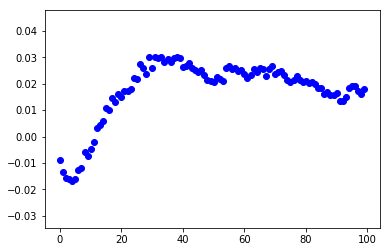

In [13]:
plt.scatter(range(num_periods), (coordination-coordination2)/num_reps, c = "blue")

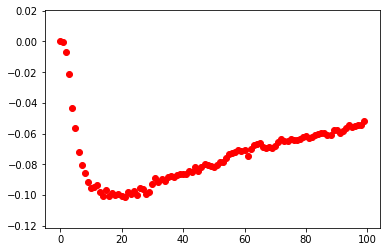

In [14]:
plt.scatter(range(num_periods), (coordination-coordination3)/num_reps, c = "red")

## 5. Exercise
What would happen if you change the minimum and maximum value of the Bernoulli bandits? Should the percentage of agreement change? 